In [1]:
# Cell 1: 라이브러리 임포트 및 BaseModel 정의

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


# BaseModel 정의
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv1_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        
        self.conv2_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.conv3_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.conv4_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.GAP = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_M(out)
        
        out = self.conv2(out)
        out = self.conv2_M(out)
        
        out = self.conv3(out)
        out = self.conv3_M(out)
        
        out = self.conv4(out)
        out = self.conv4_M(out)
        
        out = self.conv5(out)
        out = self.GAP(out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [2]:
class PadToSquare(object):
    """이미지 크기를 최대 크기로 패딩하여 정사각형으로 만듭니다."""
    def __init__(self, padding_value=0):
        self.padding_value = padding_value
        self.to_tensor = transforms.ToTensor()  # PIL 이미지 -> Tensor
        self.to_pil = transforms.ToPILImage()  # Tensor -> PIL 이미지

    def __call__(self, image):
        # PIL 이미지를 텐서로 변환
        image_tensor = self.to_tensor(image)

        # 현재 이미지 크기 가져오기
        _, height, width = image_tensor.shape
        max_size = max(height, width)

        # 패딩 계산 (좌, 상, 우, 하)
        padding = (0, 0, max_size - width, max_size - height)  # (left, top, right, bottom)

        # 패딩 추가 (텐서에 패딩)
        padded_tensor = F.pad(image_tensor, padding, value=self.padding_value)

        # 텐서를 다시 PIL 이미지로 변환
        padded_image = self.to_pil(padded_tensor)
        return padded_image

# 데이터 디렉토리 설정
train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/train'
test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/test'

# 데이터 전처리: MNIST 이미지를 RGB 채널로 처리
transform = transforms.Compose([
    PadToSquare(),  # 이미지 크기를 가장 큰 크기로 맞추기 위해 패딩
    transforms.Resize((228, 228)),
    transforms.ToTensor(),        # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# 데이터셋 크기 확인
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# 데이터 클래스 확인
print(f"Classes: {train_dataset.classes}")


Number of training samples: 1000
Number of test samples: 100
Classes: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'football', 'golf_ball', 'shuttlecock', 'tennis_ball', 'volleyball']


In [3]:
# Cell 3: 학습 환경 설정 및 옵티마이저 정의

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BaseModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 조기 종료 파라미터 설정
early_stopping_patience = 10  # 개선되지 않으면 10 에폭 후 종료
best_test_loss = float('inf')  # 최적의 검증 손실
patience_counter = 0  # 개선되지 않은 에폭 수 카운트

# 모델 가중치 저장을 위한 경로
save_path = 'sportsball.pth'


Using device: cuda


In [4]:
# Cell 4: Feature Extraction 및 평가 함수 정의

def extract_features(model, loader, device):
    features, labels_list = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Conv-Blocks 통과
            out = model.conv1(images)
            out = model.conv1_M(out)

            out = model.conv2(out)
            out = model.conv2_M(out)

            out = model.conv3(out)
            out = model.conv3_M(out)

            out = model.conv4(out)
            out = model.conv4_M(out)

            out = model.conv5(out)
            out = model.GAP(out)
            latent = out.view(out.size(0), -1)

            features.append(latent.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

            # 메모리 정리
            del images, labels, out, latent
            torch.cuda.empty_cache()

    features = np.concatenate(features, axis=0)
    return features, np.array(labels_list)

def plot_tsne(features, labels, num_classes=10):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for class_idx in range(num_classes):
        idx = labels == class_idx
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {class_idx}', alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Features")
    plt.show()


Epoch [1/100]
Train Loss: 2.2991, Train Acc: 15.80%
Test Loss: 2.0487, Test Acc: 18.00%
Model weights saved.
Epoch [2/100]
Train Loss: 2.1104, Train Acc: 23.80%
Test Loss: 2.6013, Test Acc: 18.00%
Patience Counter: 1/10
Epoch [3/100]
Train Loss: 2.0360, Train Acc: 27.20%
Test Loss: 3.6034, Test Acc: 19.00%
Patience Counter: 2/10
Epoch [4/100]
Train Loss: 2.0086, Train Acc: 26.50%
Test Loss: 2.1548, Test Acc: 18.00%
Patience Counter: 3/10
Epoch [5/100]
Train Loss: 1.9652, Train Acc: 28.60%
Test Loss: 2.2801, Test Acc: 25.00%
Patience Counter: 4/10
Extracting features for t-SNE and clustering metrics...


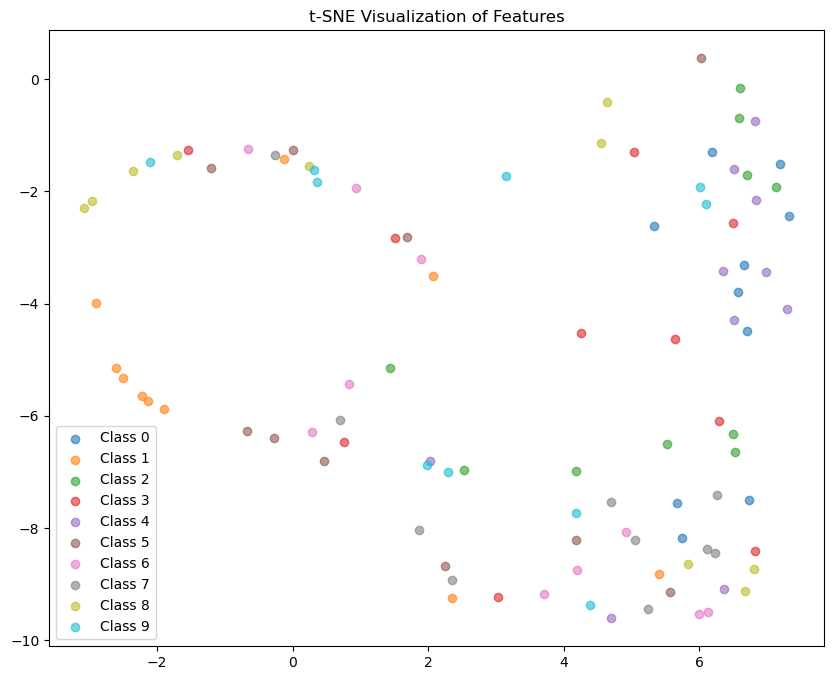

Silhouette Score: -0.2154, Davies-Bouldin Index: 6.5798


In [ ]:
# Cell 5: 메인 학습 루프

for epoch in range(100):
    # Training Loop
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Evaluation Loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del images, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/100]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # 학습률 조정 (ReduceLROnPlateau 사용)
    scheduler.step(test_loss)

    # test_loss 개선 시 가중치 저장
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # 개선이 있었으므로 카운터 초기화
        torch.save(model.state_dict(), save_path)  # 모델 가중치 저장
        print("Model weights saved.")
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{early_stopping_patience}")

    # Early Stopping 체크
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # 5 에폭마다 t-SNE 시각화 및 군집화 지표 계산
    if (epoch + 1) % 5 == 0:
        print("Extracting features for t-SNE and clustering metrics...")
        test_features, test_labels = extract_features(model, test_loader, device)

        # t-SNE 시각화
        plot_tsne(test_features, test_labels, num_classes=10)

        # Silhouette Score 및 Davies-Bouldin Index 계산
        silhouette = silhouette_score(test_features, test_labels)
        dbi = davies_bouldin_score(test_features, test_labels)
        print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")


In [ ]:
# Cell 6: Latent Classifier 정의

# Latent Classifier 정의
class LatentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
# Cell 7: Latent Feature 추출 및 TensorDataset 변환

# 모델 가중치 로드 (필요 시)
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

# Latent Feature 추출
print("Extracting train features...")
train_features, train_labels = extract_features(model, train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features(model, test_loader, device)

# TensorDataset으로 변환
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset_latent = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset_latent = torch.utils.data.TensorDataset(test_features, test_labels)

# DataLoader 생성
train_loader_latent = torch.utils.data.DataLoader(train_dataset_latent, batch_size=64, shuffle=True)
test_loader_latent = torch.utils.data.DataLoader(test_dataset_latent, batch_size=64, shuffle=False)

print(f"Number of training latent samples: {len(train_dataset_latent)}")
print(f"Number of test latent samples: {len(test_dataset_latent)}")


In [ ]:
# Cell 8: Latent Classifier 학습

# Latent Classifier 초기화
latent_classifier = LatentClassifier(input_dim=train_features.shape[1], num_classes=10).to(device)
criterion_latent = nn.CrossEntropyLoss()
optimizer_latent = optim.Adam(latent_classifier.parameters(), lr=0.001)

# Latent Classifier 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    # Training Loop
    latent_classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for features, labels in train_loader_latent:
        features, labels = features.to(device), labels.to(device)

        optimizer_latent.zero_grad()
        outputs = latent_classifier(features)
        loss = criterion_latent(outputs, labels)
        loss.backward()
        optimizer_latent.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del features, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader_latent)

    # Evaluation Loop
    latent_classifier.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in test_loader_latent:
            features, labels = features.to(device), labels.to(device)
            outputs = latent_classifier(features)
            loss = criterion_latent(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del features, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader_latent)

    print(f"Latent Classifier Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


In [ ]:
# Cell 10: Latent Feature를 사용한 추가 분석 (예: t-SNE, 분류기 학습 등)
# Latent Feature 추출: 저장된 모델 가중치를 사용하여 테스트 데이터의 Latent Feature를 추출합니다.
# t-SNE 시각화: 추출된 Feature를 2차원으로 축소하여 시각화합니다.
# 군집화 지표 계산: Silhouette Score와 Davies-Bouldin Index를 계산하여 Latent Space의 군집화 품질을 평가합니다.

# 예시: 이미 저장된 모델 가중치를 로드한 후 Latent Feature 추출 및 시각화
# model = BaseModel().to(device)
# model.load_state_dict(torch.load('sportsball_weights.pth'))
# model.eval()

# Latent Feature 추출
test_features, test_labels = extract_features(model, test_loader, device)

# t-SNE 시각화
plot_tsne(test_features, test_labels, num_classes=10)

# 군집화 지표 계산
silhouette = silhouette_score(test_features, test_labels)
dbi = davies_bouldin_score(test_features, test_labels)
print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")
